In [5]:
import numpy as np
import pandas as pd
from typing import Tuple, List
import matplotlib.pyplot as plt
import pandas_bokeh
import copy

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

In [6]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [7]:
# !pip install -U xgboost

## Helper functions

In [8]:
def get_champagne(years: Tuple[int, int] = (2018, 2023),
                  normal_days: dict =  {'n': 1000, 'p': 0.02},
                  weekdays: dict = {4: {'n': 1800, 'p': 0.03},
                                    5: {'n': 2000, 'p': 0.05}},
                  special_events: dict = {(29, 12): {'n': 1500, 'p': 0.1},
                                          (30, 12): {'n': 2000, 'p': 0.2},
                                          (31, 12): {'n': 2000, 'p': 0.7}}):
    """Model for sparkling wine demand"""
    df = pd.DataFrame({
        'date': pd.date_range(f'{years[0]}-01-01', f'{years[1]}-12-31')    
    })
    df['weekday'] = df.date.dt.weekday
    df['month'] = df.date.dt.month
    df['monthday'] = df.date.dt.day
    
    normal_days_amount = np.random.binomial(**normal_days, size=len(df))
    df['amount'] = normal_days_amount
    
    if weekdays:
        for wd, params in weekdays.items():
            mask = df.weekday == wd
            df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
    
    if special_events:
        for d, params in special_events.items():
            mask = (df.monthday == d[0]) & (df.month == d[1]) 
            df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
            col_name = f'special_event_{d[0]}_{d[1]}'
            df[col_name] = 0
            df.loc[mask, col_name] = 1
    
    return df

In [9]:
def train_loop(models: List[object], 
               X_train: pd.DataFrame, 
               y_train: pd.DataFrame):
    for model in models.values():
        model.fit(X_train, y_train)

def test_loop(models: List[object], 
               df_results: pd.DataFrame, 
               X_test: pd.DataFrame):        
    for name, model in models.items():
        y_hat = model.predict(X_test)
        df_results[name] = y_hat 

In [10]:
# def to_cat(X: pd.DataFrame):
#     return X.astype('category')

def special_day_as_cat(X: pd.DataFrame):
    special_cols = X.filter(regex='special').columns.tolist()
    X[special_cols] = X[special_cols].astype('category')
    return X

## Common config

In [20]:
START_YEAR = 2018
END_YEAR = 2023

SPLIT_DATE = '2022-12-31'

TARGET = ['amount']
MODELS = {
    'lightgbm_rmse': LGBMRegressor(objective='rmse'),
    'lightgbm_rmse_goss': LGBMRegressor(objective='rmse', boosting_type='goss'),
    'lightgbm_rmse_lt': LGBMRegressor(objective='rmse', linear_trees=True),
    'xgboost_rmse': XGBRegressor(objective='reg:squarederror'),
    'catboost_rmse': CatBoostRegressor(objective='RMSE', verbose=0),
    
    'lightgbm_tweedie': LGBMRegressor(objective='tweedie'),
    'xgboost_tweedie': XGBRegressor(objective='reg:tweedie'),
    'catboost_tweedie': CatBoostRegressor(objective='Tweedie:variance_power=1.5', verbose=0),
    
    'lightgbm_mae': LGBMRegressor(objective='mae'),
    'xgboost_mae': XGBRegressor(objective='reg:absoluteerror'),
    'catboost_mae': CatBoostRegressor(objective='MAE', verbose=0),
    
    'lightgbm_poisson': LGBMRegressor(objective='poisson'),
    'xgboost_poisson': XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.),
    'catboost_poisson': CatBoostRegressor(objective='Poisson', verbose=0),
    
    'sklearn_rf_rmse': RandomForestRegressor(criterion='squared_error'),
   # 'sklearn_svr': SVR(),
    
    'sklearn_linear': LinearRegression()    
}

## Data

In [21]:
data = get_champagne(years=(START_YEAR, END_YEAR),
                    special_events={(31, 12): {'n': 2000, 'p': 0.7}})

train_data = data.query('date <= @SPLIT_DATE')
test_data = data.query('date > @SPLIT_DATE')

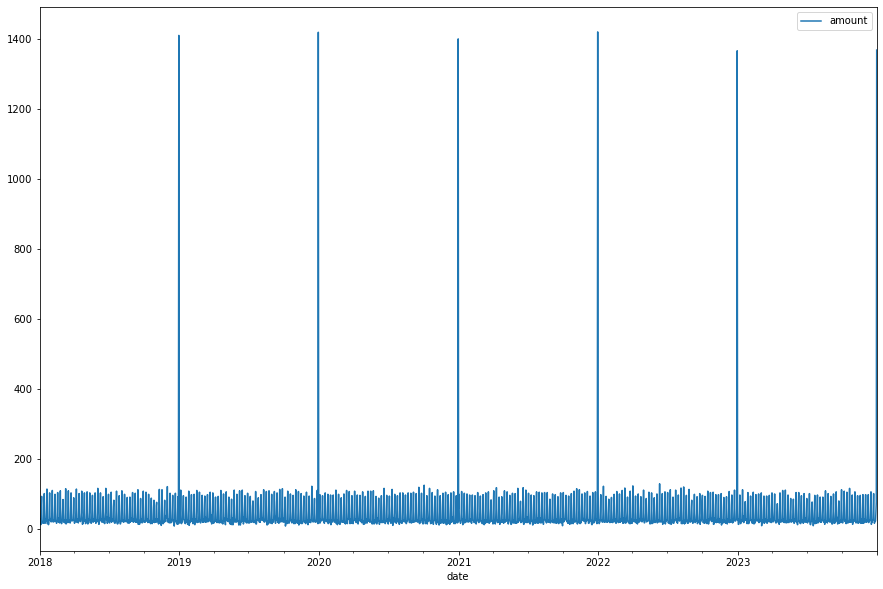

In [22]:
data.plot(x='date', y='amount')

In [23]:
train_data.query("(monthday == 31) & (month == 12)")

,date,weekday,month,monthday,amount,special_event_31_12
364,2018-12-31,0,12,31,1411,1
729,2019-12-31,1,12,31,1420,1
1095,2020-12-31,3,12,31,1401,1
1460,2021-12-31,4,12,31,1421,1
1825,2022-12-31,5,12,31,1367,1


## Without special event flag

In [24]:
FEATURES_1 = ['monthday', 
              'month',
              'weekday']


X_train_1, y_train_1 = train_data[FEATURES_1], train_data[TARGET]
X_test_1, y_test_1, df_results_1 = test_data[FEATURES_1], test_data[TARGET], test_data[TARGET + ['date']]

models_1 = copy.deepcopy(MODELS)
train_loop(models=models_1, X_train=X_train_1, y_train=y_train_1)
test_loop(models=models_1, df_results=df_results_1, X_test=X_test_1)

/tmp/ipykernel_8712/3094805290.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/tmp/ipykernel_8712/3094805290.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results[name] = y_hat


In [25]:
df_results_1 = df_results_1 \
    .set_index('date') \
    .query('date == "2023-12-31"').T
df_results_1.columns = pd.MultiIndex.from_arrays([df_results_1.columns.tolist(), ['no_flag']])
df_results_1

,2023-12-31
,no_flag
amount,1369.000000
lightgbm_rmse,846.794400
lightgbm_rmse_goss,775.351706
lightgbm_rmse_lt,1259.080669
xgboost_rmse,1367.299683
catboost_rmse,872.869581
lightgbm_tweedie,222.096568
xgboost_tweedie,473.765839
catboost_tweedie,8.399858


## With special day flag

In [26]:
FEATURES_2 = ['monthday', 
             'month',
             'weekday',
             'special_event_31_12']

X_train_2, y_train_2 = train_data[FEATURES_2], train_data[TARGET]
X_test_2, y_test_2, df_results_2 = test_data[FEATURES_2], test_data[TARGET], test_data[TARGET + ['date']]

models_2 = copy.deepcopy(MODELS) 
models_2.update({
    'lightgbm_rmse_special_as_cat': make_pipeline(FunctionTransformer(special_day_as_cat),
                                                  LGBMRegressor(objective='rmse')),
    'catboost_rmse_special_as_cat': make_pipeline(FunctionTransformer(special_day_as_cat),
                                                CatBoostRegressor(objective='RMSE', verbose=0, 
                                                                  cat_features=['special_event_31_12']))
})
train_loop(models=models_2, X_train=X_train_2, y_train=y_train_2)
test_loop(models=models_2, df_results=df_results_2, X_test=X_test_2)

/tmp/ipykernel_8712/3094805290.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/home/krzysztof/.local/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/tmp/ipykernel_8712/3094805290.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results[name] = y_hat
/home/krzysztof/.local/lib/python3.8

In [27]:
df_results_2 = df_results_2 \
    .set_index('date') \
    .query('date == "2023-12-31"').T 
df_results_2.columns = pd.MultiIndex.from_arrays([df_results_2.columns.tolist(), ['special_day_flag']])
df_results_2

,2023-12-31
,special_day_flag
amount,1369.000000
lightgbm_rmse,846.794400
lightgbm_rmse_goss,775.351706
lightgbm_rmse_lt,1259.080669
xgboost_rmse,1366.825317
catboost_rmse,964.930185
lightgbm_tweedie,222.096568
xgboost_tweedie,625.958374
catboost_tweedie,40.240907


## Summary 

In [28]:
summary = \
    pd.concat([
        df_results_1, #.add_suffix('no_flag'),
        df_results_2 # .add_suffix('_special_day_flag')
    ], axis=1)
summary

2023-12-31                 
                                  no_flag special_day_flag
amount                        1369.000000      1369.000000
lightgbm_rmse                  846.794400       846.794400
lightgbm_rmse_goss             775.351706       775.351706
lightgbm_rmse_lt              1259.080669      1259.080669
xgboost_rmse                  1367.299683      1366.825317
catboost_rmse                  872.869581       964.930185
lightgbm_tweedie               222.096568       222.096568
xgboost_tweedie                473.765839       625.958374
catboost_tweedie                 8.399858        40.240907
lightgbm_mae                    25.102966        25.102966
xgboost_mae                     21.252853        21.252853
catboost_mae                   605.433649       130.661122
lightgbm_poisson               109.057477       109.057477
xgboost_poisson                       NaN              NaN
catboost_poisson                24.605849        94.201787
sklearn_rf_rmse               1014.790000      1371.650000
sklearn_linear                  80.075960      1427.697730
lightgbm_rmse_special_as_cat          NaN       846.794400
catboost_rmse_special_as_cat          NaN       999.456883